In [98]:
library(XML)
library(TDA)
library(sets)
library(repr)
library(pracma)
library(gtools)
library(foreach)
library(stringr)
library(R.matlab)
library(doParallel)
library(scatterplot3d)

#### Setup Ripser

In [3]:
## Parse raw output from Ripser
parseOutput = function( output ){
    
    ## Number of intervals by dimension
    indices            = grep( "persistence intervals in dim " , output , value = FALSE )
    maxDimension       = length( indices ) - 1
    indices            = c( indices , length( output ) )
    
    ## Convert output in matrix
    diagram = matrix(, ncol = 3, nrow = 0 )
    
    ## Loop each group of intervals by dimension
    for( dim in 0:maxDimension ){
        
        ## Select intervals
        if( dim == maxDimension ){
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] ) ]
        }else{
            intervals = output[ ( indices[ dim + 1 ] + 1):( indices[ dim + 2 ] - 1 ) ]
        }
        
        ## Removed lines from output
        intervals = grep( "\\[\\d*\\.?\\d+\\,\\d*\\.?\\d+\\)" , intervals , value = TRUE )
        
        ## Remove punctuation from intervals
        intervals = gsub( "(\\s|\\[|\\))" , "" , intervals )
        
        ## Split interval and convert to numeric
        intervals = as.numeric( unlist( strsplit( intervals , "," ) ) )
        
        ## Convert ouput in matrix
        intervals = matrix( intervals , ncol = 2 , byrow = T )
        
        ## Add dimension column
        intervals = cbind( rep( dim , nrow( intervals ) ) , intervals )
        
        ## Add intervals to diagram
        diagram = rbind( diagram, intervals )
        
    }
    
    ## Format matrix to diagram format
    colnames(diagram) = c("dimension", "Birth", "Death")
    
    return(diagram)    
}

## Calculate rips diagram using Ripser library
ripserDiag = function(X, dimension, threshold, format = "point-cloud"){
    
    # Ripser likes to read files in, so use a temporary file
    f = tempfile()
    write.table(X, f, col.names = FALSE, row.names = FALSE)
    
    ## Set parameters as text
    dimension = as.character( dimension )
    threshold = as.character( threshold )
    
    ## Run Ripser using system command
    ripserOut = system2("/home/dbhaskar92/ripser/ripser", 
                        args = c("--dim", dimension, "--threshold", threshold, "--format", format , f), 
                        stdout = TRUE)
    
    return(parseOutput(ripserOut))
}

#### Get list of simulations from remote file server

In [4]:
url = "http://167.99.155.161:8000/MRC/Data/swarm_simulations/"
doc = htmlParse(url)
links = xpathSApply(doc, "//a/@href")
sim_dirs = vector("list")
for (i in seq(1, length(links))){
    remote_item = unname(links[i])
    if (str_sub(remote_item,start=-1) == .Platform$file.sep){
           sim_dirs[i] = remote_item
    }
}
paste(sim_dirs)

[1] "data_icR_1_ilR_1/" "data_icR_1_ilR_2/" "data_icR_1_ilR_3/"
 [4] "data_icR_1_ilR_4/" "data_icR_1_ilR_5/" "data_icR_2_ilR_1/"
 [7] "data_icR_2_ilR_2/" "data_icR_2_ilR_3/" "data_icR_2_ilR_4/"
[10] "data_icR_2_ilR_5/" "data_icR_3_ilR_1/" "data_icR_3_ilR_2/"
[13] "data_icR_3_ilR_3/" "data_icR_3_ilR_4/" "data_icR_3_ilR_5/"
[16] "data_icR_4_ilR_1/" "data_icR_4_ilR_2/" "data_icR_4_ilR_3/"
[19] "data_icR_4_ilR_4/" "data_icR_4_ilR_5/" "data_icR_5_ilR_1/"
[22] "data_icR_5_ilR_2/" "data_icR_5_ilR_3/" "data_icR_5_ilR_4/"
[25] "data_icR_5_ilR_5/"

#### Store (icR, ilR) parameter values for simulations of interest 

In [5]:
double_ring = list(list(1,1), list(2,2), list(3,3))
single_mill = list(list(2,1), list(3,1), list(4,1))
collective_swarm = list(list(1,2), list(1,3), list(1,4), list(1,5), 
                        list(2,3), list(2,4), list(2,5),
                        list(3,4), list(3,5))
mixed_phenotype = list(list(4,2), list(5,1))
double_mill = list(list(3,2))

stored_sims = c(double_ring, single_mill, double_mill, collective_swarm, mixed_phenotype)
paste(stored_sims)

[1] "list(1, 1)" "list(2, 2)" "list(3, 3)" "list(2, 1)" "list(3, 1)"
 [6] "list(4, 1)" "list(3, 2)" "list(1, 2)" "list(1, 3)" "list(1, 4)"
[11] "list(1, 5)" "list(2, 3)" "list(2, 4)" "list(2, 5)" "list(3, 4)"
[16] "list(3, 5)" "list(4, 2)" "list(5, 1)"

#### Read MAT file stored on the fileserver over the network

In [6]:
remote_mat_read <- function(r_url){
    
    mat_data = readMat(r_url)
    N = mat_data$N            # number of particle, 200
    alpha = mat_data$alpha    # fixed param, 1.5 
    beta = mat_data$beta      # fixed param, 0.5
    cA = mat_data$cA          # fixed param, 1.0
    cR = mat_data$cR
    iR = mat_data$iR
    lA = mat_data$lA          # fixed param, 1.0
    lR = mat_data$lR
    tseries = mat_data$t
    sim_data = mat_data$z
    tpoints = length(tseries) # number of timesteps, 2001
    
    if (length(sim_data) == tpoints * 4 * N){
        xpos = matrix(nrow = N, ncol = tpoints)
        ypos = matrix(nrow = N, ncol = tpoints)
        xvel = matrix(nrow = N, ncol = tpoints)
        yvel = matrix(nrow = N, ncol = tpoints)
        for (itr in seq(1, length(tseries))){
            xpos[,itr] = sim_data[itr, 1:N]
            ypos[,itr] = sim_data[itr, (N+1):(2*N)]
            xvel[,itr] = sim_data[itr, (2*N+1):(3*N)]
            yvel[,itr] = sim_data[itr, (3*N+1):(4*N)]
        }
        return(list("N" = N, "cR" = cR, "lR" = lR, "iR" = iR,
                   "xpos" = xpos, "ypos" = ypos, "xvel" = xvel, "yvel" = yvel))
    } else {
        print("ERROR: Unexpected file size.")
        return(NULL)
    }
    
}

#### Get simulation data given parameter values

In [7]:
obtain_sim_url <- function(icR, ilR, iR){
    
    sep = .Platform$file.sep
    sim_folder = paste('data_icR_', icR, '_ilR_', ilR, sep="")
    mat_file = paste('data_icR_', icR, '_ilR_', ilR, '_iR_', iR, '.mat', sep="")
    return(paste(url, sim_folder, sep, mat_file, sep=""))
    
}

#### Plot simulation

In [8]:
plot_sim <- function(xpos, ypos, tpoint){
    
    options(repr.plot.width=5, repr.plot.height=5)
    plot(xpos[,tpoint], ypos[,tpoint], xlab="X", ylab="Y")
    
}

#### Get max and min position of all simulations over all time points
**Warning:** Serial computation - *very slow*

In [15]:
max_pos = 0
min_pos = 0
max_vel = 0
min_vel = 0

for (sim in sim_dirs){
    
    icR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[3]))
    ilR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[5]))
    
    if (any(sapply(stored_sims, identical, list(icR, ilR)))){
        
        # get list of mat files (for all realizations) for each simulation parameter
        
        remote_folder = paste(url, sim, sep="")
        doc = htmlParse(remote_folder)
        links = xpathSApply(doc, "//a/@href")
        sim_files = vector("list")
        for (i in seq(1, length(links))){
            remote_item = unname(links[i])
            if (str_sub(remote_item,start=-4) == ".mat"){
                sim_files[i] = remote_item
            }
        }
        sim_files = mixedsort(paste(sim_files))
        
        cat(paste("Found", length(sim_files), "simulation files in", sim, "\n"))
        
        # for the first 25 realizations/replicates

        for (replicate in sim_files[1:25]){

            mat_url = paste(remote_folder, replicate, sep="")
            sim_data = remote_mat_read(mat_url)

            # compute max and min position
            max_sim_pos = max(max(sim_data$xpos), max(sim_data$ypos))
            min_sim_pos = min(min(sim_data$xpos), min(sim_data$ypos))
            
            # compute max and min velocity
            max_sim_vel = max(max(sim_data$xvel), max(sim_data$yvel))
            min_sim_vel = min(min(sim_data$xvel), min(sim_data$yvel))
            
            if (max_sim_pos > max_pos){
                max_pos = max_sim_pos 
            }
            if (min_sim_pos < min_pos){
                min_pos = min_sim_pos
            }
            
            if (max_sim_vel > max_vel){
                max_vel = max_sim_vel 
            }
            if (min_sim_vel < min_vel){
                min_vel = min_sim_vel
            }
            
        }
            
    }
       
}

print(c("Max. position found: ", max_pos))
print(c("Min. position found: ", min_pos))

print(c("Max. velocity found: ", max_vel))
print(c("Min. velocity found: ", min_vel))

Found 100 simulation files in data_icR_1_ilR_1/ 
Found 100 simulation files in data_icR_1_ilR_2/ 
Found 100 simulation files in data_icR_1_ilR_3/ 
Found 100 simulation files in data_icR_1_ilR_4/ 
Found 100 simulation files in data_icR_1_ilR_5/ 
Found 100 simulation files in data_icR_2_ilR_1/ 
Found 100 simulation files in data_icR_2_ilR_2/ 
Found 100 simulation files in data_icR_2_ilR_3/ 
Found 100 simulation files in data_icR_2_ilR_4/ 
Found 100 simulation files in data_icR_2_ilR_5/ 
Found 100 simulation files in data_icR_3_ilR_1/ 
Found 100 simulation files in data_icR_3_ilR_2/ 
Found 100 simulation files in data_icR_3_ilR_3/ 
Found 100 simulation files in data_icR_3_ilR_4/ 
Found 100 simulation files in data_icR_3_ilR_5/ 
Found 100 simulation files in data_icR_4_ilR_1/ 
Found 100 simulation files in data_icR_4_ilR_2/ 
Found 100 simulation files in data_icR_5_ilR_1/ 
[1] "Max. position found: " "155.052590115819"     
[1] "Min. position found: " "-168.219665788761"    
[1] "Max. velo

#### In parallel, normalize simulation data and compute Crocker plots

In [17]:
cores = detectCores()
cl = makeCluster(cores[1]-2)
registerDoParallel(cl)
cat(c("Number of cores:",cores))

Number of cores: 12

In [9]:
max_pos = 12
min_pos = -12
max_vel = 12 
min_vel = -12

In [19]:
for (sim in sim_dirs){
    
    icR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[3]))
    ilR = as.double(gsub(.Platform$file.sep, '', unlist(strsplit(sim, "_"))[5]))
    
    if (any(sapply(stored_sims, identical, list(icR, ilR)))){
        
        cat(c("Processing:", sim, "\n"))
        
        # get list of mat files (for all realizations) for each simulation parameter
        
        remote_folder = paste(url, sim, sep="")
        doc = htmlParse(remote_folder)
        links = xpathSApply(doc, "//a/@href")
        sim_files = vector("list")
        for (i in seq(1, length(links))){
            remote_item = unname(links[i])
            if (str_sub(remote_item,start=-4) == ".mat"){
                sim_files[i] = remote_item
            }
        }
        sim_files = mixedsort(paste(sim_files))
        
        # for the first 100 realizations/replicates

        out <- foreach(j=1:100, .combine=cbind, .packages=c('R.matlab','pracma')) %dopar% {

            replicate = sim_files[j]
            mat_url = paste(remote_folder, replicate, sep="")
            sim_data = remote_mat_read(mat_url)
            
            cfname = paste('/media/dbhaskar92/ExtraDrive1/Research/MRC/ripser_crocker_log_vel/', 
                          'data_icR_', icR, '_ilR_', ilR, '_iR_', j, '_CD_pos.csv', sep="")
            
            ofname = paste('/media/dbhaskar92/ExtraDrive1/Research/MRC/ripser_order_params_log_vel/', 
                          'data_icR_', icR, '_ilR_', ilR, '_iR_', j, '_order_params.csv', sep="")
            
            # normalize
            sim_data$xpos = (sim_data$xpos - min_pos)/(max_pos - min_pos)
            sim_data$ypos = (sim_data$ypos - min_pos)/(max_pos - min_pos)
            sim_data$xvel = (sim_data$xvel - min_vel)/(max_vel - min_vel)
            sim_data$yvel = (sim_data$yvel - min_vel)/(max_vel - min_vel)
            
            N = dim(sim_data$xpos)[1]
            ntpoints = dim(sim_data$xpos)[2]
            
            # for every 23rd time point (87 total time points)
            tsteps = seq(1, ntpoints, by=23)
            ntsteps = length(tsteps)
            
            # delta(eps) = 1e-4
            eps_vals = logseq(0.0001, 1, n = 200) #seq(0, 1, by=0.0001)
            num_eps = length(eps_vals)
            
            dim0Crocker = vector(mode = "list", length = ntsteps*num_eps)
            dim1Crocker = vector(mode = "list", length = ntsteps*num_eps)
            orderparams = vector(mode = "list", length = ntsteps)
            
            k = 0
            m = 0
            
            for (tp in tsteps){
                
                xdata = sim_data$xpos[,tp]
                ydata = sim_data$ypos[,tp]
                xv = sim_data$xvel[,tp]
                yv = sim_data$yvel[,tp]

                # compute persistence homology using ripser
                homology <- ripserDiag(cbind(xdata, ydata, xv, yv), 1, 5)
                intervals = as.data.frame(homology)
                dim0 = intervals[intervals$dimension==0,]
                dim1 = intervals[intervals$dimension==1,]

                num_feats_dim0 = dim(dim0)[1]
                num_feats_dim1 = dim(dim1)[1]

                # compute CROCKER plot
                for (eps in eps_vals){
        
                    betti0 = sum((dim0$Birth < eps) & (dim0$Death > eps))
                    betti1 = sum((dim1$Birth < eps) & (dim1$Death > eps))
                    
                    k = k + 1
                    
                    if (k == 1){
                        dim0Crocker[k] = toString(c(k, tp, 0, eps, N))
                    } else {
                        dim0Crocker[k] = toString(c(k, tp, 0, eps, betti0+1))
                    }
                    
                    dim1Crocker[k] = toString(c(ntsteps*num_eps + k, tp, 1, eps, betti1))

                }
            
                # compute order params

                v_norm = sqrt(xv^2 + yv^2)

                # center of mass
                c_x = mean(xdata)
                c_y = mean(ydata)

                # mean centered positions
                r_x = xdata - c_x
                r_y = ydata - c_y      
                r_norm = sqrt(r_x^2 + r_y^2)

                # cross product
                rvcross = r_x*yv - r_y*xv

                # polarization vector
                P = sqrt((sum(xv)/sum(v_norm))^2 + (sum(yv)/sum(v_norm))^2)

                # angular momentum
                Mang = abs(sum(rvcross)/sum(v_norm*r_norm))

                # absolute angular momentum
                Mabs = abs(sum(abs(rvcross))/sum(v_norm*r_norm))

                # distance matrices in x,y
                Xdiff = as.matrix(dist(xdata))
                Ydiff = as.matrix(dist(ydata))

                # total distance matrices in R^2
                D = sqrt(Xdiff^2 + Ydiff^2)
                # remove zeros
                for (l in seq(1, length(D), nrow(D)+1)){
                    D[l] = Inf
                }

                # sum mins from each row
                min_sum = 0
                for (l in 1:N) {
                    min_sum = min_sum + min(D[l,])
                }
                nnd = min_sum/N

                m = m + 1
                orderparams[m] = toString(c(tp, P, Mang, Mabs, nnd))
            
            }
            
            # write CROCKER data to file
            sink(cfname)
            cat(as.character(c(dim0Crocker, dim1Crocker)), sep='\n')
            sink()
            
            # write order parameters to file
            sink(ofname)
            cat(as.character(orderparams), sep='\n')
            sink()
            
            return(replicate)
            
        }
        
        cat(c(out, "\n"))
        cat("\n")
    }
       
}

Processing: data_icR_1_ilR_1/ 
data_icR_1_ilR_1_iR_1.mat data_icR_1_ilR_1_iR_2.mat data_icR_1_ilR_1_iR_3.mat data_icR_1_ilR_1_iR_4.mat data_icR_1_ilR_1_iR_5.mat data_icR_1_ilR_1_iR_6.mat data_icR_1_ilR_1_iR_7.mat data_icR_1_ilR_1_iR_8.mat data_icR_1_ilR_1_iR_9.mat data_icR_1_ilR_1_iR_10.mat data_icR_1_ilR_1_iR_11.mat data_icR_1_ilR_1_iR_12.mat data_icR_1_ilR_1_iR_13.mat data_icR_1_ilR_1_iR_14.mat data_icR_1_ilR_1_iR_15.mat data_icR_1_ilR_1_iR_16.mat data_icR_1_ilR_1_iR_17.mat data_icR_1_ilR_1_iR_18.mat data_icR_1_ilR_1_iR_19.mat data_icR_1_ilR_1_iR_20.mat data_icR_1_ilR_1_iR_21.mat data_icR_1_ilR_1_iR_22.mat data_icR_1_ilR_1_iR_23.mat data_icR_1_ilR_1_iR_24.mat data_icR_1_ilR_1_iR_25.mat data_icR_1_ilR_1_iR_26.mat data_icR_1_ilR_1_iR_27.mat data_icR_1_ilR_1_iR_28.mat data_icR_1_ilR_1_iR_29.mat data_icR_1_ilR_1_iR_30.mat data_icR_1_ilR_1_iR_31.mat data_icR_1_ilR_1_iR_32.mat data_icR_1_ilR_1_iR_33.mat data_icR_1_ilR_1_iR_34.mat data_icR_1_ilR_1_iR_35.mat data_icR_1_ilR_1_iR_36.mat data_i

In [12]:
stopCluster(cl)

#### Example: Generate CROCKER plot for one simulation

In [433]:
# 4, 2, 5
mat_url = obtain_sim_url(1, 1, 1)
sim_data = remote_mat_read(mat_url)
str(sim_data)

List of 8
 $ N   : num [1, 1] 200
 $ cR  : num [1, 1] 0.1
 $ lR  : num [1, 1] 0.1
 $ iR  : num [1, 1] 1
 $ xpos: num [1:200, 1:2001] 0.166 -0.441 1 0.395 0.706 ...
 $ ypos: num [1:200, 1:2001] -0.9 -0.113 -0.831 -0.283 0.22 ...
 $ xvel: num [1:200, 1:2001] -0.919 -0.608 0.935 -0.419 0.07 ...
 $ yvel: num [1:200, 1:2001] -0.349 -0.6 0.839 0.537 0.585 ...


In [434]:
sim_data$xpos = (sim_data$xpos - min_pos)/(max_pos - min_pos)
sim_data$ypos = (sim_data$ypos - min_pos)/(max_pos - min_pos)
sim_data$xvel = (sim_data$xvel - min_vel)/(max_vel - min_vel)
sim_data$yvel = (sim_data$yvel - min_vel)/(max_vel - min_vel)

In [435]:
N = dim(sim_data$xpos)[1]
ntpoints = dim(sim_data$xpos)[2]

In [437]:
tsteps = seq(1, ntpoints, by=23)  # 2001/3 = 667 time points, 2001/23 = 87 time points
ntsteps = length(tsteps)

eps_vals = logseq(0.0001, 1, n = 200)  
num_eps = length(eps_vals)

dim0Crocker = vector(mode = "list", length = (ntsteps-1)*num_eps)
dim1Crocker = vector(mode = "list", length = (ntsteps-1)*num_eps)
orderparams = vector(mode = "list", length = ntsteps-1)

i = 0
k = 0

for (tp in tsteps){  
    
    if (tp == 1){
        next
    }
    
    xdata = sim_data$xpos[,tp]
    ydata = sim_data$ypos[,tp]
    xv = sim_data$xvel[,tp]
    yv = sim_data$yvel[,tp]
    xdata_old = sim_data$xpos[,tp-5]
    ydata_old = sim_data$ypos[,tp-5]
    
    # run ripser
    homology <- ripserDiag(cbind(xdata, ydata, xdata_old, ydata_old), 1, 50)
    intervals = as.data.frame(homology)
    dim0 = intervals[intervals$dimension==0,]
    dim1 = intervals[intervals$dimension==1,]
    
    num_feats_dim0 = dim(dim0)[1]
    num_feats_dim1 = dim(dim1)[1]
    
    # compute CROCKER plot
    for (eps in eps_vals){
        
        betti0 = sum((dim0$Birth < eps) & (dim0$Death > eps))
        betti1 = sum((dim1$Birth < eps) & (dim1$Death > eps))
        
        i = i + 1
        
        if (i == 1){
            dim0Crocker[i] = toString(c(i, tp, 0, eps, N))
        } else {
            dim0Crocker[i] = toString(c(i, tp, 0, eps, betti0+1))
        }
        
        dim1Crocker[i] = toString(c(ntsteps*num_eps + i, tp, 1, eps, betti1))
        
    }
    
    # compute order params
    
    # norm of the velocity
    v_norm = sqrt(xv^2 + yv^2)
    
    # center of mass
    c_x = mean(xdata)
    c_y = mean(ydata)
      
    # mean centered positions
    r_x = xdata - c_x
    r_y = ydata - c_y      
    r_norm = sqrt(r_x^2 + r_y^2)
    
    # cross product
    rvcross = r_x*yv - r_y*xv

    # polarization vector
    P = sqrt((sum(xv)/sum(v_norm))^2 + (sum(yv)/sum(v_norm))^2)

    # angular momentum
    Mang = abs(sum(rvcross)/sum(v_norm*r_norm))

    # absolute angular momentum
    Mabs = abs(sum(abs(rvcross))/sum(v_norm*r_norm))
    
    # distance matrices in x,y
    Xdiff = as.matrix(dist(xdata))
    Ydiff = as.matrix(dist(ydata))
        
    # total distance matrices in R^2
    D = sqrt(Xdiff^2 + Ydiff^2)
    # remove zeros
    for (j in seq(1, length(D), nrow(D)+1)){
        D[j] = Inf
    }
    
    # sum mins from each row
    min_sum = 0
    for (j in 1:N) {
        min_sum = min_sum + min(D[j,])
    }
    nnd = min_sum/N
    
    k = k + 1
    orderparams[k] = toString(c(tp, P, Mang, Mabs, nnd))
    
}

cat("Expected: total number of rows = # time points * # eps values = 86 * 200 = 17200\n")
cat(c("Got: ", i))

Expected: total number of rows = # time points * # eps values = 86 * 200 = 17200
Got:  17200

In [438]:
xdata = sim_data$xpos[,2001]
ydata = sim_data$ypos[,2001]
xv = sim_data$xvel[,2001]
yv = sim_data$yvel[,2001]
xdata_old = sim_data$xpos[,1996]
ydata_old = sim_data$ypos[,1996]

We are unable to get get two loops using position and velocity because points in position space are very dense whereas they are more sparely located in velocity space. We only detect the loop in velocity space.

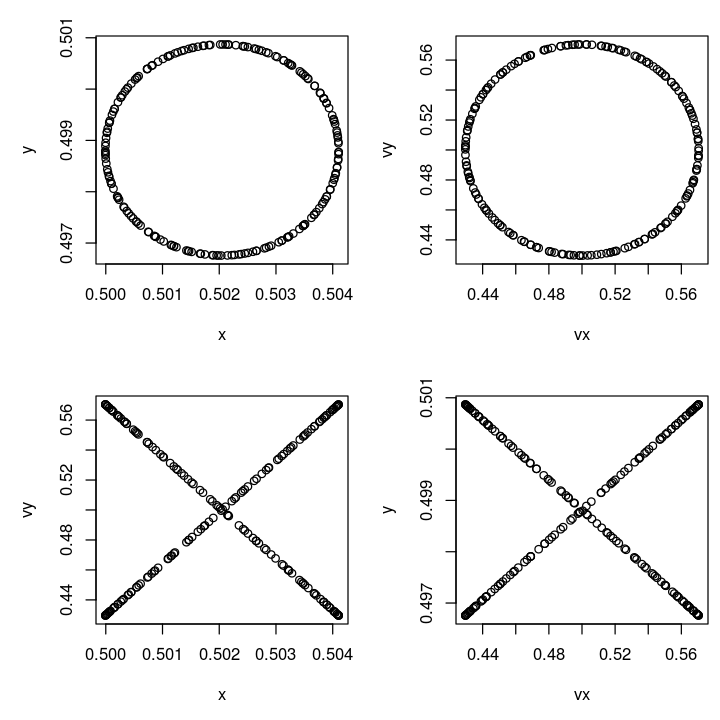

In [439]:
par(mfrow = c(2, 2), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=6,repr.plot.height=6)

plot(xdata, ydata, xlab="x", ylab="y")
plot(xv, yv, xlab="vx", ylab="vy")
plot(xdata, yv, xlab="x", ylab="vy")
plot(xv, ydata, xlab="vx", ylab="y")

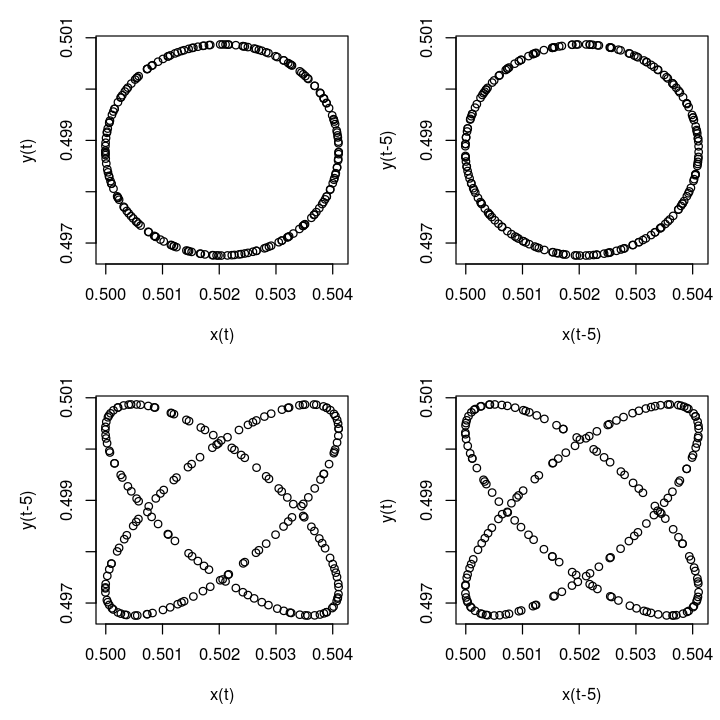

In [440]:
par(mfrow = c(2, 2), mai = c(0.8, 0.8, 0.3, 0.1))
options(repr.plot.width=6,repr.plot.height=6)

plot(xdata, ydata, xlab="x(t)", ylab="y(t)")
plot(xdata_old, ydata_old, xlab="x(t-5)", ylab="y(t-5)")
plot(xdata, ydata_old, xlab="x(t)", ylab="y(t-5)")
plot(xdata_old, ydata, xlab="x(t-5)", ylab="y(t)")

In [441]:
homology <- ripserDiag(cbind(xdata, ydata, xdata_old, ydata_old), 1, 50)
intervals = as.data.frame(homology)
dim0 = intervals[intervals$dimension==0,]
dim1 = intervals[intervals$dimension==1,]

In [442]:
dim1

,dimension,Birth,Death
153,1,0.00242212,0.00242266
154,1,0.00242173,0.00242257
155,1,0.00242172,0.00242318
156,1,0.00242110,0.00242180
157,1,0.00242106,0.00242444
158,1,0.00242101,0.00242180
159,1,0.00242093,0.00242473
160,1,0.00242090,0.00242337
161,1,0.00242088,0.00242184
162,1,0.00242084,0.00242281


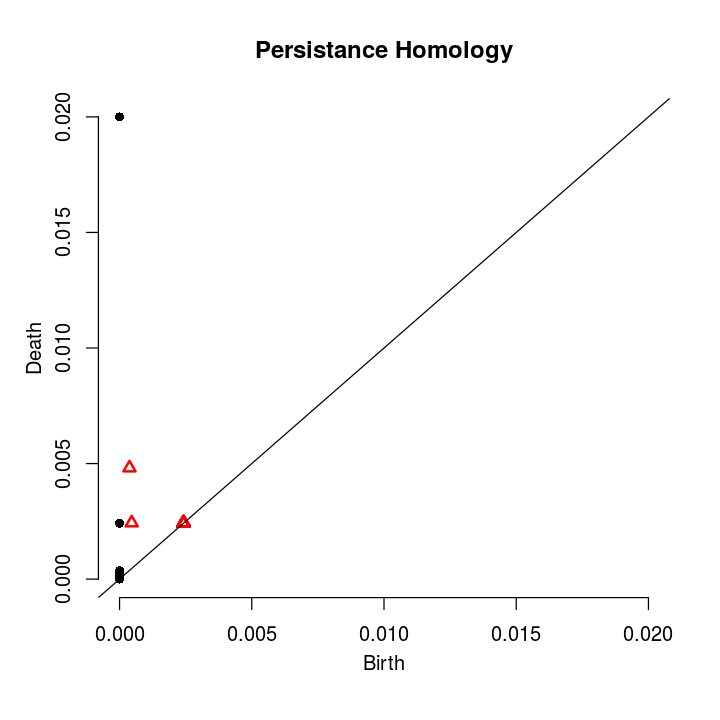

In [443]:
DiagRipsSph <- ripsDiag(X = cbind(xdata, ydata, xdata_old, ydata_old), 1, 0.02, library = c("GUDHI"), 
                        location = TRUE, printProgress = FALSE)
plot(DiagRipsSph[["diagram"]], main = "Persistance Homology")

In [444]:
fileConn = file("data_icR_1_ilR_1_iR_1_CD_pos_td.csv")
writeLines(as.character(c(dim0Crocker, dim1Crocker)), fileConn)
close(fileConn)

In [445]:
fileConn = file("data_icR_1_ilR_1_iR_1_order_params.csv")
writeLines(as.character(orderparams), fileConn)
close(fileConn)